## User behavior analysis on TaoBao App

Dataset link: https://tianchi.aliyun.com/dataset/dataDetail?dataId=46

What is in the train_user.csv:

- user_id
- item_id
- behavior_type
- user_geohash
- item_category
- time

## Import library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data overview

In [0]:
data_user = pd.read_csv('train_user.csv')

In [3]:
data_user.shape

(802757, 6)

In [4]:
data_user.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98607707,64749712,1,NaN,2883,2014-12-18 11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10
4,98145908,290208520,1,NaN,13926,2014-12-16 21


In [5]:
data_user.dtypes

user_id           int64
item_id           int64
behavior_type     int64
user_geohash     object
item_category     int64
time             object
dtype: object

In [0]:
# missing value
missingTotal = data_user.isnull().sum()

In [10]:
missingTotal

user_id               0
item_id               0
behavior_type         0
user_geohash     550130
item_category         0
time                  1
dtype: int64

We can see the column, user_geohash has the most null values. But we won't use it in this project.

In [17]:
data_user[data_user.time.isnull()]

,user_id,item_id,behavior_type,user_geohash,item_category,time
802756,106090167,332265276,1,NaN,37,NaN


There is a null time here, which I will use forward fill to fill the NA.

In [0]:
data_user.time = data_user.time.fillna(method = 'ffill')

Also we can see the 'time' column needs to be cleaned, bucause it contains date and the time both in one element. We need to refine the date and time to be more detailed level in order to analyze the trends.

In [13]:
data_user.loc[0, 'time']

'2014-12-06 02'

In [0]:
# separate date and time (hrs)
data_user['date'] = data_user['time'].map(lambda s: s.split(' ')[0])
data_user['hour'] = data_user['time'].map(lambda s: s.split(' ')[1])

In [24]:
data_user.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,98047837,232431562,1,NaN,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,NaN,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,NaN,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,NaN,13926,2014-12-16 21,2014-12-16,21


In [0]:
# method II: using re when complex split pattern
# data_user['time'].map(lambda s: re.compile(' ').split(s)[0])

Then, we should convert the date and time into date type, currently they are both string.

In [25]:
data_user['date'] = pd.to_datetime(data_user['date'])
data_user['time'] = pd.to_datetime(data_user['time'])
data_user['hour'] = data_user['hour'].astype('int64')
data_user.dtypes

user_id                   int64
item_id                   int64
behavior_type             int64
user_geohash             object
item_category             int64
time             datetime64[ns]
date             datetime64[ns]
hour                      int64
dtype: object

In [26]:
data_user.loc[0, 'time']

Timestamp('2014-12-06 02:00:00')

In [27]:
# see if there are some outliers or improper time/date
# sort the dataset by time and also index by that
data_user = data_user.sort_values(by='time', ascending=True)
data_user = data_user.reset_index(drop=True)
data_user.describe()

,user_id,item_id,behavior_type,item_category,hour
count,8.027570e+05,8.027570e+05,802757.000000,802757.000000,802757.000000
mean,7.172247e+07,2.023267e+08,1.105354,6839.368040,14.783169
std,4.156197e+07,1.167838e+08,0.457151,3810.354984,6.516357
min,6.118000e+03,6.680000e+02,1.000000,8.000000,0.000000
25%,3.466242e+07,1.014538e+08,1.000000,3687.000000,10.000000
50%,7.319659e+07,2.020050e+08,1.000000,6194.000000,16.000000
75%,1.078682e+08,3.036172e+08,1.000000,10290.000000,20.000000
max,1.424302e+08,4.045617e+08,4.000000,14080.000000,23.000000


We can see all column contain common data, no weird record.

In [28]:
min(data_user.date)

Timestamp('2014-11-18 00:00:00')

In [29]:
max(data_user.date)

Timestamp('2014-12-18 00:00:00')

We can ensure the dateset is only for all the user behaviors on TaoBao App for one month, from 2014-11-18 to 2014-12-18.

## Data exploration

### Daily page view (PV) and unique user (UU)

Page view: Also can be called page impression, which is a commonly used measure to show the user activity on a website.

Unique user: Unique users is a measure of the distribution of content to a number of distinct consumers. It can be considered as a common way of measuring the popularity of the website. However, sometimes it may overstate because now people have more than devides for one account (or more).

In [0]:
pv_daily = data_user.groupby('date')['user_id'] \
            .count().reset_index() \
            .rename(columns={'user_id': 'pv'})
            
uu_daily = data_user.groupby('date')['user_id'] \
            .apply(lambda x:x.drop_duplicates().count()) \
            .reset_index() \
            .rename(columns={'user_id': 'uu'})

Text(0.5, 1.0, 'Daily unique user')

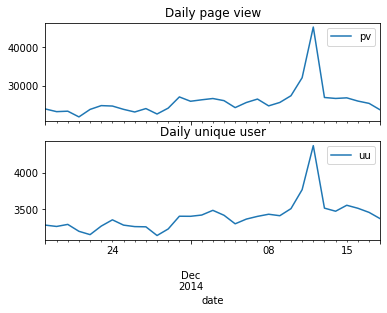

In [32]:
fig, axes = plt.subplots(2, 1, sharex=True)
pv_daily.plot(x='date', y='pv', ax=axes[0])
uu_daily.plot(x='date', y='uu', ax=axes[1])
axes[0].set_title('Daily page view')
axes[1].set_title('Daily unique user')

In [0]:
# how many users in the dataset
user_num = data_user['user_id'].nunique()

In [0]:
pv_12 = pv_daily.loc[pv_daily.date == '2014-12-12', 'pv'].item()

In [0]:
uu_12 = uu_daily.loc[uu_daily.date == '2014-12-12', 'uu'].item()

In [74]:
print('User activity on 12 Dec is: {}%'.format(round(uu_12/user_num, 2)*100.0))
print('Avg user page view on 12 Dec is: {}'.format(round(pv_12/uu_12, 2)))

User activity on 12 Dec is: 67.0%
Avg user page view on 12 Dec is: 10.35


The page view goes to peak on 12 Dec, which is a famous shopping holiday in China, similar to Boxing day and Black Friday.

Also, we can see there is a similar trend between total page view and number of unique user but very different in the scale and the user active percentage is nearly 67% on 12 Dec. Each active user on that day on average viewed 10 pages.

### Hourly page view (PV) and unique user (UU)

In [0]:
pv_hour = data_user.groupby('hour')['user_id'] \
            .count().reset_index() \
            .rename(columns={'user_id': 'pv_hour'})
            
uu_hour = data_user.groupby('hour')['user_id'] \
            .apply(lambda x:x.drop_duplicates().count()) \
            .reset_index() \
            .rename(columns={'user_id': 'uu_hour'})

Text(0.5, 1.0, 'Hourly unique user')

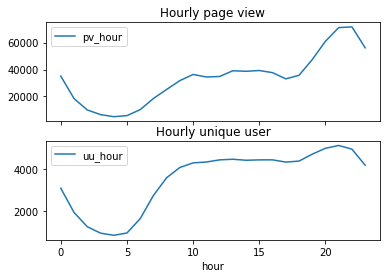

In [76]:
fig, axes = plt.subplots(2, 1, sharex=True)
pv_hour.plot(x='hour', y='pv_hour', ax=axes[0])
uu_hour.plot(x='hour', y='uu_hour', ax=axes[1])
axes[0].set_title('Hourly page view')
axes[1].set_title('Hourly unique user')

Activity decreases sharply from 0 am to 5 am, and then bounces back to a very high activity at 10 am and becomes smooth, consistently raises from 18 pm and then goes to highest at 21 pm. In short, users are most active starting from 18 pm.

### Hourly PV analysis for different behavior types

Text(0.5, 1.0, 'PV other different behavior types')

<Figure size 720x432 with 0 Axes>

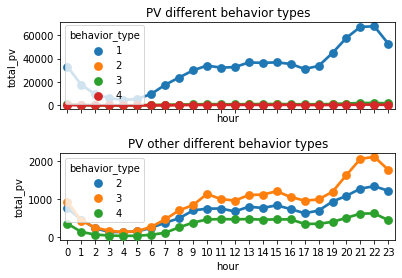

In [78]:
plt.figure(figsize=(10, 6))
pv_detail = data_user.groupby(['hour', 'behavior_type'])['user_id'] \
              .count().reset_index().rename(columns={'user_id':'total_pv'})
              
fig, axes = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.5)
sns.pointplot(x='hour', y='total_pv', hue='behavior_type', data=pv_detail, ax=axes[0])
sns.pointplot(x='hour', y='total_pv', hue='behavior_type', data=pv_detail[pv_detail.behavior_type!=1], ax=axes[1])
axes[0].set_title('PV different behavior types')
axes[1].set_title('PV other different behavior types')

In [0]:
data_user_behavior = data_user.groupby('behavior_type')['user_id'].count() \
                .reset_index().rename(columns={'user_id':'Behavior_count'})

data_user_behavior['Percentage'] = data_user_behavior.Behavior_count/data_user_behavior.Behavior_count.sum()

In [113]:
data_user_behavior

,behavior_type,Behavior_count,Percentage
0,1,756387,0.942237
1,2,16013,0.019948
2,3,22510,0.028041
3,4,7847,0.009775


Click, collect, add-to-cart and payment, the corresponding values are 1, 2, 3 and 4, respectively. We can see clicking are the most active operation, which is 94%, and adding to cart is more active than collect.

### Number of user payments behavior

Text(0.5, 1.0, 'Monthly user payments distribution')

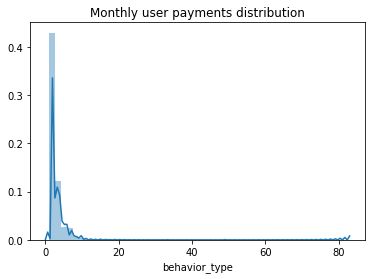

In [95]:
data_user_buy = data_user[data_user.behavior_type==4].groupby('user_id')['behavior_type'].count()

sns.distplot(data_user_buy, kde=True)
plt.title('Monthly user payments distribution')

We can see almost users pay no more than 10 times monthly. Therefore, users who buy more than 10 times are more valuable or at least need more attention.

### Average revenue per paying user (ARPPU)

ARPPU: defined as the total revenue divided by the number of paying users. Because we do not have revenue, replace the revenue with daily total payments count. That provides the company a granular view at a per user or unit basis and allows it to track revenue sources and growth.

Text(0.5, 1.0, 'Daily ARPPU')

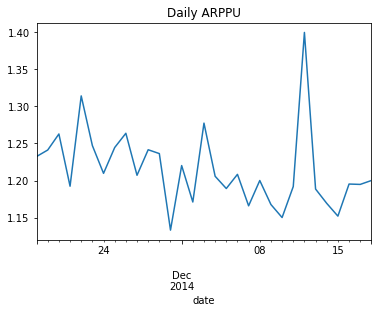

In [115]:
# how many payments in total for each user daily
user_buy_daily = data_user[data_user.behavior_type==4].groupby(['date','user_id'])['behavior_type'] \
                  .count().reset_index().rename(columns={'behavior_type':'total'})

# compute the average payments per user daily
user_buy_daily.groupby('date').apply(lambda x:x.total.sum()/x.total.count()).plot()
plt.title('Daily ARPPU')

### Average revenue per user (ARPU)

ARPU: defined as avg revenue per user, not limited to paying users, here again replace revenue with payments count.

Text(0.5, 1.0, 'Daily ARPU')

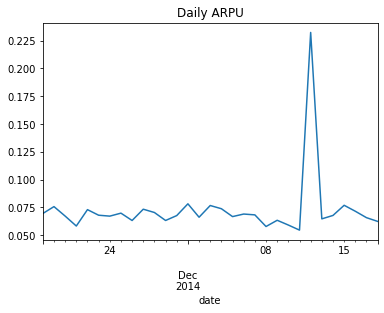

In [116]:
# because we will use three cols for grouping, add one more col to hold the results
data_user['operation'] = 1
data_user_buy2 = data_user.groupby(['date','user_id','behavior_type'])['operation'] \
                  .count().reset_index().rename(columns={'operation':'total'})
                  
# for each selected date, there is a dataframe(x) to do apply below
data_user_buy2.groupby('date').apply(lambda x: x[x.behavior_type==4].total.sum()/x.user_id.nunique()).plot()
plt.title('Daily ARPU')

The difference between ARPPU and ARPU is that people are not the same group, the prior one is paying users, the later one is all active users who do any operations (whether paying or not).

### Daily afford rate

Defined as how many users paid/active users.

Note: count() and sum() are different in this case because one user can operate/pay multiple times daily. So sum() is far much more than count().

Text(0.5, 1.0, 'Daily afford rate')

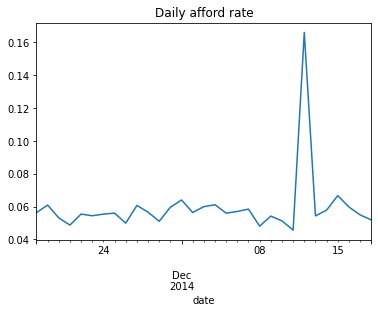

In [117]:
# here we care about number of paying users (count), not paying times (sum)
data_user_buy2.groupby('date').apply(lambda x: x[x.behavior_type==4].total.count()/x.user_id.nunique()).plot()
plt.title('Daily afford rate')

### Rebuying behavior analysis

#### Rebuying rate

Rebuying user refers to users who buy more than two days in a month.

In [123]:
# the date must be count by distinct because multiple payments in one day is considered once
# rename here change the series name, not column name
date_rebuy = data_user[data_user.behavior_type==4].groupby('user_id')['date'] \
              .apply(lambda x: x.nunique()).reset_index().rename(columns={'date':'rebuy_count'})

rate = len(date_rebuy[date_rebuy.rebuy_count>=2])/len(date_rebuy)
print('Rebuying rate is {}'.format(round(rate, 2)))

Rebuying rate is 0.47


#### When people rebuy with regard to time lag

Text(0, 0.5, 'How many people rebuy in this time lag')

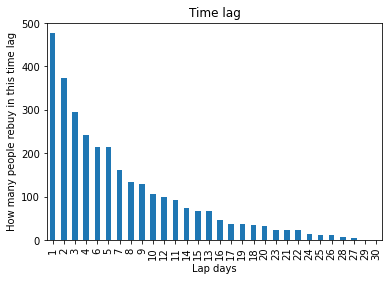

In [125]:
data_day_buy = data_user[data_user.behavior_type==4].groupby(['user_id','date'])['operation'].count().reset_index()
# diff(1) will compute the two elements difference, but the first element will be nan, dropna() to delete that row
data_user_buy4 = data_day_buy.groupby('user_id')['date'].apply(lambda x: x.sort_values().diff(1).dropna())
# extract day number from '12 days'
data_user_buy4 = data_user_buy4.map(lambda x: x.days)
data_user_buy4.value_counts().plot(kind='bar')
plt.title('Time lag')
plt.xlabel('Lap days')
plt.ylabel('How many people rebuy in this time lag')

We can see the paying behavior is decreasing with the time gap between the first buying date. Need to pay attention to encourage users to rebuy within 10 days.

### User missing analysis

In [0]:
# len(df) is faster than df.shape[0] is faster than df.count()
pv_all = len(data_user['user_id'])

# What portion of users operate 4 behaviors in duration
data_user_count = data_user.groupby('behavior_type')['operation'].count() \
                    .apply(lambda x: x/pv_all).reset_index().rename(columns={'operation':'operation portion'})

In [128]:
data_user_count

,behavior_type,operation portion
0,1,0.942237
1,2,0.019948
2,3,0.028041
3,4,0.009775


### Different item category analysis

We can see four behaviors for each category below.

In [129]:
data_category = data_user.groupby(['item_category', 'behavior_type'])['operation'].count() \
                  .unstack(level=1).rename(columns={1:'click',2:'collect',3:'add-to-cart',4:'buy'}).fillna(0)
# unstack - pivot table using the index in the specified level
data_category.head()

behavior_type,click,collect,add-to-cart,buy
item_category,,,,
8,58.0,0.0,1.0,0.0
10,11.0,0.0,0.0,0.0
11,572.0,6.0,4.0,0.0
12,9.0,0.0,0.0,0.0
13,6.0,0.0,0.0,0.0


Therefore, we can draw suggestions based on the user missing stage for each category of products.